# Dan Crouthamel – SMU NLP Course — Homework 8

## Assignment Objectives

Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:

1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

3.	For extra credit, analyze sentiment of chunks as follows:  
  a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).   
  b.	Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see.
  
Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings.

## Solution

For this assignment, I created a new dataset of 100 movies, 50 with positive sentiment (defined by shortest review having a rating of 10) and another 50 movies with negative sentiment (defined by shortest review having a rating of 1). The code from my previous assignment was modified to accomplish this. 

### Library Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

### Scrape Data from IMDB

The code below will scrape the *shortest* review from 100 different movies, 50 with postive sentiment and another 50 with negative sentiment (as defined by rating).

In [ ]:
# As mentioned in HW5, some of the code below is from the link below. I made further modifications.
# https://shravan-kuchkula.github.io/scrape_imdb_movie_reviews/#

def getSoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

def getMovieTags(soup):
    tags = soup.find_all('a', attrs={'class': None})
    tags = [tag.attrs['href'] for tag in tags if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]
    
    return list(dict.fromkeys(tags))

def getLongestReviewText(soup):
    user_reviews = [tag.getText().strip() for tag in soup.find_all('div', attrs={'class':'text show-more__control'})]

    # Need better error handling here. Can throw an error if there are no reviews.
    return min(user_reviews, key=len)

def getMovieGenres(soup):
    genres = [tag.getText().strip() for tag in soup.find_all('span', attrs={'class':'genre'})]
    
    return genres

def getMovieNames(soup):
    names = soup.find_all('img', attrs={'class': 'loadlate'})

    return [tag.attrs['alt'] for tag in names]

base_url = 'https://www.imdb.com'

# search_url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=7.0,10.0
# &num_votes=50000,&sort=user_rating,desc&count=100'''

search_url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=4.0,10.0
&num_votes=50000,&genres=crime&view=simple,desc&count=100'''

# get the soup object for main api url
movies_soup = getSoup(search_url)

# Scrape IMDB and get movie information
movie_tags = getMovieTags(movies_soup)
movie_names = getMovieNames(movies_soup)
movie_genres = getMovieGenres(movies_soup)
movie_links = [base_url + tag for tag in movie_tags]

# # >>>
# movie_review_links = [base_url + tag + 'reviews' for tag in movie_tags]
# movie_soups = [getSoup(link) for link in movie_review_links]
# review_texts = [getLongestReviewText(movie_soup) for movie_soup in movie_soups]

# # Create a dataframe with all the movie info
# columns = ['Movie Name', 'Movie Genres', 'Movie Review URL', 'Longest Review Text']
# df = pd.DataFrame(columns=columns)
# df['Movie Name'] = movie_names
# df['Movie Genres'] = movie_genres
# df['Movie Review URL'] = movie_review_links
# df['Longest Review Text'] = review_texts
# # >>>

# >>> Save for HW8, bring back sentiment for prediction
# p_movie_review_links = [base_url + tag + 'reviews?sort=helpfulnessScore&dir=desc&ratingFilter=10' for tag in movie_tags]
# n_movie_review_links = [base_url + tag + 'reviews?sort=helpfulnessScore&dir=desc&ratingFilter=1' for tag in movie_tags]

movie_review_links = []
cnt = 0
#print(type(movie_review_links))
for tag in movie_tags:
    if cnt % 2 == 0:
        movie_review_links.append(base_url + tag + "reviews?sort=helpfulnessScore&dir=desc&ratingFilter=10")
        #movie_review_links[cnt] = base_url + tag + 'reviews?sort=helpfulnessScore&dir=desc&ratingFilter=10'
    else:
        movie_review_links.append(base_url + tag + "reviews?sort=helpfulnessScore&dir=desc&ratingFilter=1")
        #movie_review_links[cnt] = base_url + tag + 'reviews?sort=helpfulnessScore&dir=desc&ratingFilter=3'
    cnt += 1
    #print(movie_review_links[cnt])

#movie_review_links = p_movie_review_links + n_movie_review_links
movie_soups = [getSoup(link) for link in movie_review_links]
review_texts = [getLongestReviewText(movie_soup) for movie_soup in movie_soups]
#review_sentiment = np.array(['positive'] * 200) + np.array(['negative'] * 200)
review_sentiment = np.array(['positive', 'negative'] * 50)

columns = ['Movie Name', 'Movie Sentiment', 'Movie Review URL', 'Movie Review Text']
df = pd.DataFrame(columns=columns)
df['Movie Name'] = movie_names
df['Movie Sentiment'] = review_sentiment
df['Movie Review URL'] = movie_review_links
df['Movie Review Text'] = review_texts
# >>>

# Save the dataframe to a csv file
df.to_csv('reviews_short.csv', index=False)
df.head()

Below we'll save off our dataset so we don't have to scrape it again later.

In [2]:
df = pd.read_csv('reviews_short.csv')
df.head(10)

,Movie Name,Movie Sentiment,Movie Review URL,Movie Review Text
0,F9: The Fast Saga,positive,https://www.imdb.com/title/tt5433138/reviews?s...,Like ridiculously. GOTG is more realistic🤣 Abs...
1,Wrath of Man,negative,https://www.imdb.com/title/tt11083552/reviews?...,This movie gave me migrane.Migrane\nits bad\nd...
2,Cruella,positive,https://www.imdb.com/title/tt3228774/reviews?s...,I really enjoyed wathcing this story About Cru...
3,Nobody,negative,https://www.imdb.com/title/tt7888964/reviews?s...,Sooo badly written and cheaply content brought...
4,The Little Things,positive,https://www.imdb.com/title/tt10016180/reviews?...,With this cast i can watch for a whole day not...
5,The Godfather,negative,https://www.imdb.com/title/tt0068646/reviews?s...,"This movie continues to be praised, but when I..."
6,Army of the Dead,positive,https://www.imdb.com/title/tt0993840/reviews?s...,What an Incredible piece of film! Totally love...
7,Promising Young Woman,negative,https://www.imdb.com/title/tt9620292/reviews?s...,What a waste of my time feel robbed of preciou...
8,The Dark Knight,positive,https://www.imdb.com/title/tt0468569/reviews?s...,My go to movie on a Friday night! Excellent al...
9,Pulp Fiction,negative,https://www.imdb.com/title/tt0110912/reviews?s...,"Golly, everyone is falling all over themselves..."


### Sentiment Analysis

Below we'll use TextBlob to calculate sentiment. Please see URL below for more information on TextBlob.

https://textblob.readthedocs.io/en/dev/index.html

The code below computes the polarity of each review and a determination if it is positive, negative, or neutral.

In [3]:
from textblob import TextBlob

df['Calculated Sentiment Score'] = df['Movie Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Calculated Sentiment'] = df['Calculated Sentiment Score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

df.head(10)

,Movie Name,Movie Sentiment,Movie Review URL,Movie Review Text,Calculated Sentiment Score,Calculated Sentiment
0,F9: The Fast Saga,positive,https://www.imdb.com/title/tt5433138/reviews?s...,Like ridiculously. GOTG is more realistic🤣 Abs...,-0.111111,negative
1,Wrath of Man,negative,https://www.imdb.com/title/tt11083552/reviews?...,This movie gave me migrane.Migrane\nits bad\nd...,-0.700000,negative
2,Cruella,positive,https://www.imdb.com/title/tt3228774/reviews?s...,I really enjoyed wathcing this story About Cru...,0.500000,positive
3,Nobody,negative,https://www.imdb.com/title/tt7888964/reviews?s...,Sooo badly written and cheaply content brought...,-0.150000,negative
4,The Little Things,positive,https://www.imdb.com/title/tt10016180/reviews?...,With this cast i can watch for a whole day not...,0.100000,positive
5,The Godfather,negative,https://www.imdb.com/title/tt0068646/reviews?s...,"This movie continues to be praised, but when I...",-0.137500,negative
6,Army of the Dead,positive,https://www.imdb.com/title/tt0993840/reviews?s...,What an Incredible piece of film! Totally love...,0.850000,positive
7,Promising Young Woman,negative,https://www.imdb.com/title/tt9620292/reviews?s...,What a waste of my time feel robbed of preciou...,-0.233333,negative
8,The Dark Knight,positive,https://www.imdb.com/title/tt0468569/reviews?s...,My go to movie on a Friday night! Excellent al...,1.000000,positive
9,Pulp Fiction,negative,https://www.imdb.com/title/tt0110912/reviews?s...,"Golly, everyone is falling all over themselves...",-0.197619,negative


### Data Preprocessing/Encoding

Next we'll perform our standard preprocessing of the data and normalize the data like we did in the previous assignment.

In [4]:
stop_words = nltk.corpus.stopwords.words('english')
#stemming = SnowballStemmer('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # stem tokens - Skipping for now
    #filtered_tokens = [stemming.stem(token) for token in filtered_tokens]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(list(df['Movie Review Text']))

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 100


Next we need to encode our data. I'm going to use the TfidfVectorizer like before and create a vectorizer to consider unigrams, bi-grams, and trigrams. These features need to occur in at least 2 movie reviews.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = nltk.corpus.stopwords.words('english')
stop_words = stop_words + ['film', 'movie', 'films', 'movies']

tf = TfidfVectorizer(ngram_range=(1,3), min_df=2, max_df=1.0, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(100, 198)


### K-means clustering

Next we'll create a K-means model and create 10 clusters. We'll also compute the average, median, max and miniumum sentiment scores for each cluster.

CLUSTER #1 - Size: 29
Key Features: ['one', 'real', 'written', 'loved', 'totally', 'wrote', 'ever', 'worst', 'tarantino', 'absolutely', 'tries', 'sad', 'way', 'like', 'see', 'last', 'scenes', 'actually', 'worth', 'make', 'years', 'masterpiece', 'worst ever', 'action', 'possibly', 'seen', 'watched', 'end', 'place', 'something', 'definitely', 'goes', 'though', 'awful', 'incredible', 'every', 'twist', 'expect', 'think', 'funny', 'seriously', 'watching', 'violent', 'first', 'seeing', 'well', 'comes', 'things', 'plot', 'pointless']
Popular Movies: ['Knives Out', 'Enola Holmes', 'Kill Bill: Vol. 1', 'Once Upon a Time in America', 'The Gentlemen', 'Point Break', 'American Gangster', 'Memories of Murder', 'Army of the Dead', 'Gone Baby Gone', '2 Fast 2 Furious', 'Nobody', 'Pulp Fiction', 'A Clockwork Orange', 'The Hateful Eight', "Ocean's Eight", 'RoboCop', 'I Care a Lot', 'Baywatch', 'Zootopia']
Average Sentiment Score: 0.05
Median Sentiment Score: 0.0
Max Sentiment Score: 1.0
Min Sentiment S

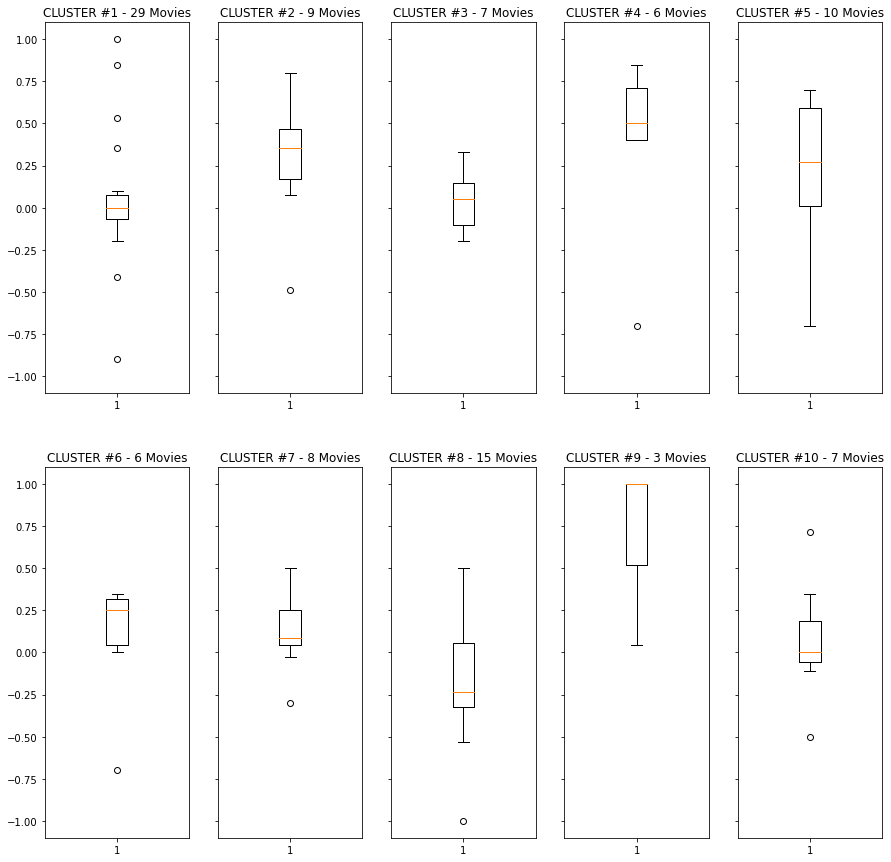

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

NUM_CLUSTERS = 10
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

movie_clusters = (df[['Movie Name', 'kmeans_cluster', 'Calculated Sentiment Score']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
movie_clusters = movie_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 50
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

fig, axs = plt.subplots(2, 5, figsize=(15, 15), sharey=True)

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Movie Name'].values.tolist()

    mean_score = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Calculated Sentiment Score'].mean()
    median_score = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Calculated Sentiment Score'].median()
    max_score = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Calculated Sentiment Score'].max()
    min_score = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Calculated Sentiment Score'].min()

    print('CLUSTER #'+str(cluster_num+1), "- Size:", cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('Popular Movies:', movies)
    print('Average Sentiment Score:', mean_score.round(2))
    print('Median Sentiment Score:', median_score.round(2))
    print('Max Sentiment Score:', max_score.round(2))
    print('Min Sentiment Score:', min_score.round(2))
    print('-'*80)

    axs[cluster_num//5, cluster_num % 5].boxplot(movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['Calculated Sentiment Score'])
    axs[cluster_num//5, cluster_num % 5].set_title('CLUSTER #'+str(cluster_num+1) + ' - ' + str(cluster_silhouette_values.shape[0]) + ' Movies')

### Questions 1 and 2 Answers

Above we can visually see better the max/min/median sentiment values for each cluster. As expected some clusters contain all sentiment, and others more positve vs negative. We saw before in the previous homework that our TF-IDF vectorizer is encoding our words into a matrix based on frequency count, so the clusters are going to represent groups based on count of similar words used in review, and not based on sentiment.

Cluster 1 = Has reviews from negative to postive, all over the place.   
Cluster 2 = Primarily Positve, but 1 negative outlier.

etc.


### Question 3

We'll use Spacy below to come up with our Noun Chunks.

In [7]:
import spacy

def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

nlp = spacy.load('en_core_web_sm')
df['Noun Chunks'] = df['Movie Review Text'].apply(getNounChunks)
df.head()

,Movie Name,Movie Sentiment,Movie Review URL,Movie Review Text,Calculated Sentiment Score,Calculated Sentiment,kmeans_cluster,Noun Chunks
0,F9: The Fast Saga,positive,https://www.imdb.com/title/tt5433138/reviews?s...,Like ridiculously. GOTG is more realistic🤣 Abs...,-0.111111,negative,9,"[GOTG, more realistic🤣 Absurd]"
1,Wrath of Man,negative,https://www.imdb.com/title/tt11083552/reviews?...,This movie gave me migrane.Migrane\nits bad\nd...,-0.700000,negative,5,"[This movie, me, migrane, Migrane]"
2,Cruella,positive,https://www.imdb.com/title/tt3228774/reviews?s...,I really enjoyed wathcing this story About Cru...,0.500000,positive,6,"[I, this story, Cruella]"
3,Nobody,negative,https://www.imdb.com/title/tt7888964/reviews?s...,Sooo badly written and cheaply content brought...,-0.150000,negative,0,"[cheaply content, us]"
4,The Little Things,positive,https://www.imdb.com/title/tt10016180/reviews?...,With this cast i can watch for a whole day not...,0.100000,positive,6,"[this cast, i, a whole day, not only 2 hours]"


Next we're going to create a list of tuples having our noun chunk sentiment scores. Note, only non zero values are saved. So the data structure below is a list of tuples (made up of chunks and their sentiment scores).

Two outputs are shown, first those chunks with the highest sentiment score and second those with the lowest sentiment score. Seems like reasonable output :)

There is a lot more we could do here. Test sentiment prediction, etc. Wish I had more time!

In [8]:
noun_chunk_sentiments = []

for chunks in df['Noun Chunks']:
    for chunk in chunks:
        score = TextBlob(chunk).sentiment.polarity
        if score != 0:
            data = (chunk, score)
            if (data not in noun_chunk_sentiments):
                noun_chunk_sentiments.append(data)

from operator import itemgetter

values = sorted(noun_chunk_sentiments, key = itemgetter(1), reverse=True)
print(values[0:10])

print()

values = sorted(noun_chunk_sentiments, key = itemgetter(1))
print(values[0:10])

[('a wonderful novel', 1.0), ('The perfect sequel', 1.0), ('masterful direction', 1.0), ('the perfect tone', 1.0), ('What an Incredible piece', 0.9), ('The beautiful contrast', 0.85), ('this beautiful atmosphere', 0.85), ('Great plot', 0.8), ('great score', 0.8), ('a great job', 0.8)]

[('boring movie', -1.0), ('the worst films', -1.0), ('worst movie', -1.0), ('Boring film', -1.0), ('the worst movie', -1.0), ('disgusting scenes', -1.0), ('Worst movie', -1.0), ('Pathetic movie', -1.0), ('its just crap', -0.8), ('violent events', -0.8)]
